In [20]:
import torch
import torchvision
import torchvision.utils as vutils
import sys
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
print(f"python Version: {sys.version.split(' ')[0]}")
print(f"torch Version: {torch.__version__}")
print(f"torchvision Version: {torchvision.__version__}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

python Version: 3.10.11
torch Version: 2.1.1+cu118
torchvision Version: 0.16.1+cu118
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
from dataclasses import dataclass
@dataclass
class Hyperparameter:
    num_classes: int        = 10
    batchsize: int          = 128
    num_epochs: int         = 50
    latent_size: int        = 32
    n_critic: int           = 5
    critic_size: int        = 1024
    generator_size: int     = 1024
    critic_hidden_size: int = 1024
    gp_lambda: float        = 10.0
    sigma: float            = 1.1
    weight_clip : float     = 2.5
hp = Hyperparameter()

In [5]:
class DPGenerator(nn.Module):
    def __init__(self):
        super(DPGenerator, self).__init__()
        self.latent_embedding = nn.Sequential(
            nn.Linear(hp.latent_size, hp.generator_size // 2),
        )
        self.condition_embedding = nn.Sequential(
            nn.Linear(hp.num_classes, hp.generator_size // 2),
        )
        self.tcnn = nn.Sequential(
        nn.ConvTranspose2d( hp.generator_size, hp.generator_size, 4, 1, 0),
        nn.BatchNorm2d(hp.generator_size),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d( hp.generator_size, hp.generator_size // 2, 3, 2, 1),
        nn.BatchNorm2d(hp.generator_size // 2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d( hp.generator_size // 2, hp.generator_size // 4, 4, 2, 1),
        nn.BatchNorm2d(hp.generator_size // 4),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d( hp.generator_size // 4, 1, 4, 2, 1),
        nn.Tanh()
        )
        
    def forward(self, latent, condition):
        vec_latent = self.latent_embedding(latent)
        vec_class = self.condition_embedding(condition)
        combined = torch.cat([vec_latent, vec_class], dim=1).reshape(-1, hp.generator_size, 1, 1)
        return self.tcnn(combined)

In [14]:
gen = DPGenerator().cuda()

In [147]:
gen.load_state_dict(torch.load("models/CGAN/Generator.pth"))

<All keys matched successfully>

In [148]:
gen.eval()

DPGenerator(
  (latent_embedding): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
  )
  (condition_embedding): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
  )
  (tcnn): Sequential(
    (0): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)

In [149]:
all_labels = torch.eye(hp.num_classes, dtype=torch.float32, device="cuda")

In [150]:
all_labels

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [151]:
required_class = 3

In [156]:
fixed_noise = torch.randn((20, hp.latent_size), device="cuda")
fixed_class_labels = all_labels[[i for i in range(hp.num_classes) for idx in range(2)]]

In [157]:
fixed_noise.shape, fixed_class_labels.shape

(torch.Size([20, 32]), torch.Size([20, 10]))

In [158]:
import numpy as np

torch.Size([20, 28, 28, 1])


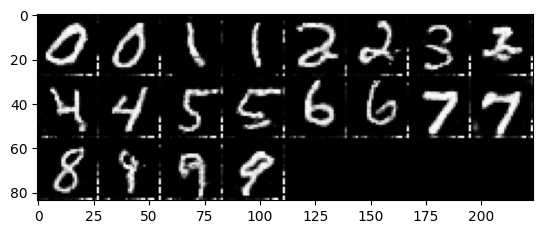

In [159]:
with torch.no_grad(): 
    # print(fixed_class_labels[0].shape, fixed_noise[0].shape)
    # fake_images = gen(fixed_noise[0].unsqueeze(0), fixed_class_labels[0].unsqueeze(0)).cpu()
    fake_images = gen(fixed_noise, fixed_class_labels).cpu()
    print(fake_images.permute(0,2,3,1).shape)
    # np.save("images", fake_images.permute(0,2,3,1).numpy())
    # np.save("labels", fixed_class_labels.cpu().numpy())
    i = vutils.make_grid(fake_images, padding=0, normalize=True)
    # print(fake_images)
    plt.imshow(i.permute(1,2,0))

In [74]:
print(fake_images)

tensor([[[[-0.9987, -0.9995, -0.9988,  ..., -0.9990, -0.9960, -0.4032],
          [-0.9999, -0.9999, -1.0000,  ..., -0.9999, -0.9997,  0.0517],
          [-0.9994, -1.0000, -0.9999,  ..., -1.0000, -0.9991,  0.3068],
          ...,
          [-0.9994, -0.9996, -1.0000,  ..., -1.0000, -1.0000, -0.9053],
          [-0.9985, -0.9997, -0.9998,  ..., -1.0000, -1.0000,  1.0000],
          [-0.8717, -0.6689, -0.3505,  ..., -1.0000, -0.9930,  0.9984]]],


        [[[-0.9969, -0.9972, -0.9965,  ..., -0.9975, -0.9947, -0.3055],
          [-0.9998, -0.9998, -0.9999,  ..., -0.9703, -0.9894,  0.6544],
          [-0.9992, -1.0000, -0.9999,  ..., -0.9950, -0.9881,  0.6954],
          ...,
          [-0.9985, -0.9998, -1.0000,  ..., -0.9999, -1.0000,  0.6618],
          [-0.9993, -0.9999, -0.9991,  ..., -0.9979, -0.9996,  1.0000],
          [-0.9038, -0.5447, -0.0245,  ..., -0.9333, -0.7629,  0.9819]]],


        [[[-0.9927, -0.9906, -0.9963,  ..., -0.9953, -0.9967, -0.4554],
          [-0.9974, -0.998

In [95]:
def generate_images(label, model, num_images, image_path, device):
    fixed_noise = torch.randn(num_images, hp.latent_size)
    fixed_class_labels = all_labels[[label for idx in range(num_images)]]
    
    with torch.no_grad():
        fake_images = gen(fixed_noise.to(device), fixed_class_labels.to(device)).cpu()
        print(fake_images.shape)
        i = vutils.make_grid(fake_images, padding=0, normalize=True)
        print(i.shape)
        plt.imshow(fake_images[0].permute(1,2,0))
        # np.save(fake_imagesimage_path)

torch.Size([1, 1, 28, 28])
torch.Size([3, 28, 28])


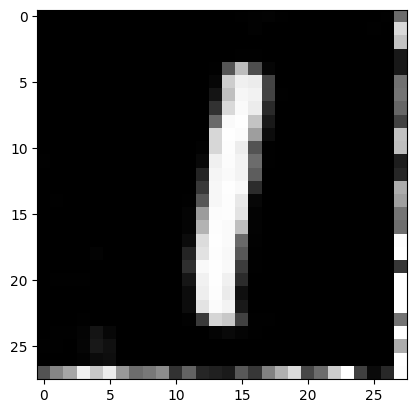

In [96]:
generate_images(1, gen, 1, "", "cuda")

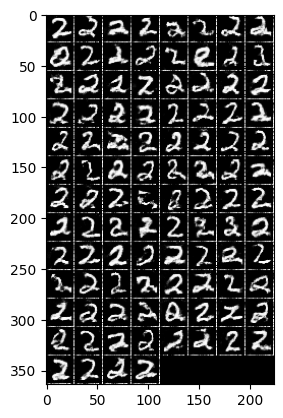

In [77]:
generate_images(2, gen, 100, "", "cuda")

In [185]:
import os
import cv2
import numpy as np

# Function to load images and labels from a given directory
def load_images_and_labels(root_folder):
    image_data = []
    labels = []

    # Get the list of subdirectories (labels) in the root folder
    subdirectories = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    for label in subdirectories:
        label_path = os.path.join(root_folder, label)

        # Iterate through each image in the label directory
        for filename in os.listdir(label_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add more image extensions if needed
                image_path = os.path.join(label_path, filename)

                # Read the image using OpenCV
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # You may want to resize the images to a consistent size
                # image = cv2.resize(image, (desired_width, desired_height))

                # Append the image data and label to the lists
                image_data.append(image)
                labels.append(label)

    return np.array(image_data), np.array(labels)

# Specify the root folder containing the labeled subdirectories
root_folder = 'base_cvae_imgs'

# Load images and labels
images, labels = load_images_and_labels(root_folder)

In [186]:
images.shape

(6000, 28, 28)

In [187]:
labels.shape

(6000,)

In [188]:
np.save("output/vae/images", images)

In [189]:
np.save("output/vae/labels", labels)